In [1]:
# LIBRARIES
# Import necessary libraries
import sys
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from CustomModel import EinarPersistorModelType1L
from CustomModel import EinarPersistorModelType2L
from CustomModel import EinarPersistorModelType3L
from CustomModel import EinarPersistorModelTypeU

In [2]:
# COPIED FUNCTIONALITY CODE
outDir = "./data/sensitiveResistantModel/"
solver_kws={'method':'LSODA', # this chooses the ODE solver. Options are those available in scipy.integrate.odeint. DOP853 is a good go-to.
            'absErr':1.0e-8, 'relErr':1.0e-6, # absolute and relative error tolerances
            'suppressOutputB':False # suppresses the output of the solver. This is useful for long simulations where you don't want to see the output.
            }

In [3]:
# MODEL TYPE: 1L
einar_model = EinarPersistorModelType1L()
d = einar_model.paramDic
d

{'DMax': 100,
 'CASE': 'Linear 1',
 'n': 1500,
 'fracRes': 0.01,
 'Cmax': 10,
 'k': 0.0004,
 'm': 0.0004,
 'u0': 0.0004,
 'v0': 0.004,
 'lambda0': 0.04,
 'lambda1': 0.001,
 'delta_d0': 0.08}

In [4]:
# FUNCTIONS

from scipy.optimize import curve_fit

def expFunc(t, n0, a):
    return n0 * np.exp(np.clip(a * t, -700, 700))

def fit(results):
    start_hr = 30*24 # Make sure the start and end hour are present within the trimmed data
    end_hr = 45*24
    filtered_df = results[(results["Time"] >= start_hr) & (results["Time"] <= end_hr)]
    x_data = filtered_df["Time"].values
    y_data = filtered_df["TumourSize"].values

    params, _ = curve_fit(expFunc, x_data, y_data, p0=[3000, -0.005])
    n0_fit, a_fit = params
    
    return a_fit
    
def simulate(params):
    cfrac = params['cfrac']

    einar_model = EinarPersistorModelType1L()
    einar_model.paramDic = params
    einar_model.initialStateList = [d['n']*(1-d['fracRes']), d['n']*d['fracRes']] # Starter values
    example_schedule = [[0, 50*24, cfrac]]

    einar_model.Simulate(example_schedule, solver_kws=solver_kws)

    results = einar_model.resultsDf

    a = fit(results)

    return (sigma(params) - a)

def sigma(params):
    cmax = params['Cmax']
    cfrac = params['cfrac']
    u_0 = params['u0']
    v_0 = params['v0']
    m = params['m']
    k = params['k']
    lambda_0 = params['lambda0']
    lambda_1 = params['lambda1']
    delta_d0 = params['delta_d0']
    
    c = cmax * cfrac
    u_c = u_0 + (k*c)
    v_c = v_0
    lambda_c = lambda_0 - delta_d0 * (c / (c+1))
    
    return 0.5*(lambda_c - u_c + lambda_1 - v_c + (((lambda_c - u_c - lambda_1 + v_c)**2) + (4 * u_c * v_c)) ** 0.5)

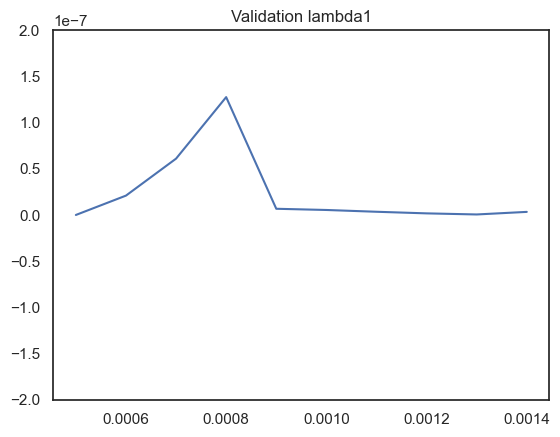

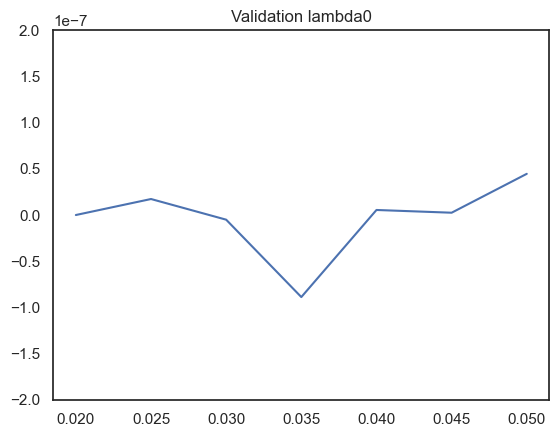

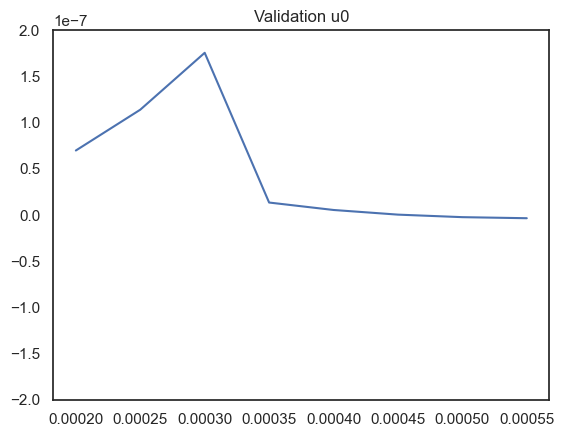

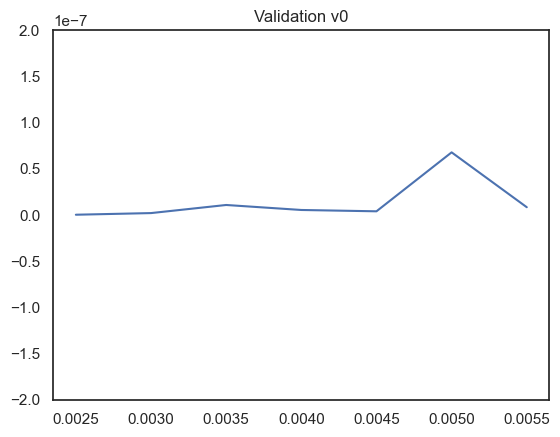

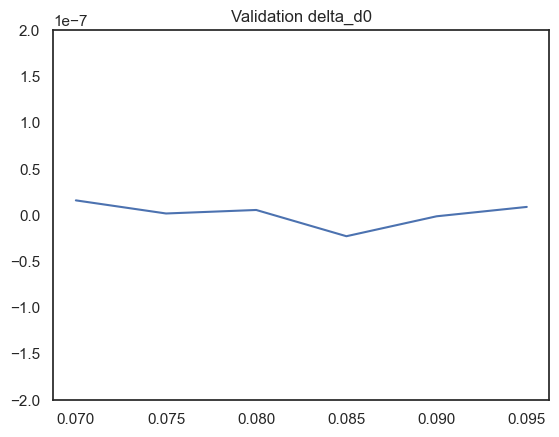

In [5]:
# HOPEFULLY HORIZONTAL LINE PLOTS

X = []
Y = []
for variable in np.arange(0.0005, 0.0015, 0.0001):
    params = {
         'DMax': 100,
         'CASE': 'Linear 1',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': 0.0004,
         'v0': 0.004,
         'lambda0': 0.04,
         'lambda1': variable,
         'delta_d0': 0.08
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
title = "Validation lambda1"
plt.title(title)
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.02, 0.051, 0.005):
    params = {
         'DMax': 100,
         'CASE': 'Linear 1',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': 0.0004,
         'v0': 0.004,
         'lambda0': variable,
         'lambda1': 0.001,
         'delta_d0': 0.08
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation lambda0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.0002, 0.0006, 0.00005):
    params = {
         'DMax': 100,
         'CASE': 'Linear 1',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': variable,
         'v0': 0.004,
         'lambda0': 0.04,
         'lambda1': 0.001,
         'delta_d0': 0.08
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation u0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.0025, 0.006, 0.0005):
    params = {
         'DMax': 100,
         'CASE': 'Linear 1',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': 0.0004,
         'v0': variable,
         'lambda0': 0.04,
         'lambda1': 0.001,
         'delta_d0': 0.08
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation v0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.07, 0.1, 0.005):
    params = {
         'DMax': 100,
         'CASE': 'Linear 1',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': 0.0004,
         'v0': 0.004,
         'lambda0': 0.04,
         'lambda1': 0.001,
         'delta_d0': variable
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation delta_d0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

In [6]:
# MODEL TYPE: 2L
einar_model = EinarPersistorModelType2L()
d = einar_model.paramDic
d

{'DMax': 100,
 'CASE': 'Linear 2',
 'n': 1500,
 'fracRes': 0.01,
 'Cmax': 10,
 'k': 0.0004,
 'm': 0.0004,
 'u0': 0.0004,
 'v0': 0.004,
 'lambda0': 0.04,
 'lambda1': 0.001,
 'delta_d0': 0.08}

In [7]:
# FUNCTIONS

from scipy.optimize import curve_fit

def expFunc(t, n0, a):
    return n0 * np.exp(np.clip(a * t, -700, 700))

def fit(results):
    start_hr = 30*24 # Make sure the start and end hour are present within the trimmed data
    end_hr = 45*24
    filtered_df = results[(results["Time"] >= start_hr) & (results["Time"] <= end_hr)]
    x_data = filtered_df["Time"].values
    y_data = filtered_df["TumourSize"].values

    params, _ = curve_fit(expFunc, x_data, y_data, p0=[3000, -0.005])
    n0_fit, a_fit = params
    
    return a_fit
    
def simulate(params):
    cfrac = params['cfrac']

    einar_model = EinarPersistorModelType2L()
    einar_model.paramDic = params
    einar_model.initialStateList = [d['n']*(1-d['fracRes']), d['n']*d['fracRes']] # Starter values
    example_schedule = [[0, 50*24, cfrac]]

    einar_model.Simulate(example_schedule, solver_kws=solver_kws)

    results = einar_model.resultsDf

    a = fit(results)

    return (sigma(params) - a)

def sigma(params):
    cmax = params['Cmax']
    cfrac = params['cfrac']
    u_0 = params['u0']
    v_0 = params['v0']
    m = params['m']
    k = params['k']
    lambda_0 = params['lambda0']
    lambda_1 = params['lambda1']
    delta_d0 = params['delta_d0']
    
    c = cmax * cfrac
    u_c = u_0
    v_c = v_0 - (m*c)
    lambda_c = lambda_0 - delta_d0 * (c / (c+1))
    
    return 0.5*(lambda_c - u_c + lambda_1 - v_c + (((lambda_c - u_c - lambda_1 + v_c)**2) + (4 * u_c * v_c)) ** 0.5)

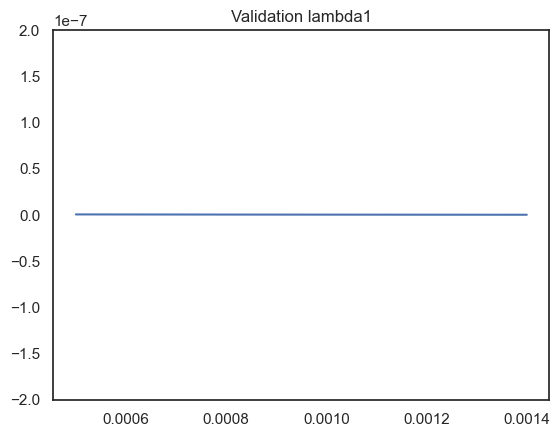

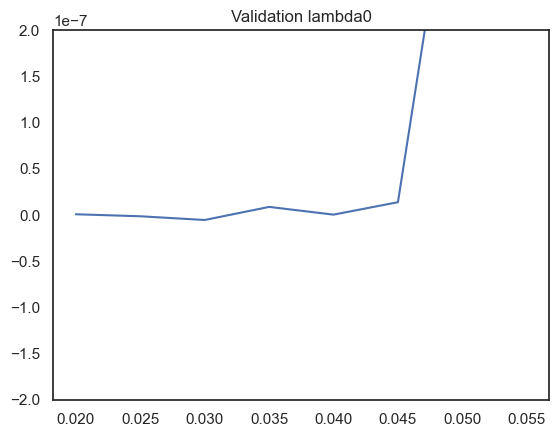

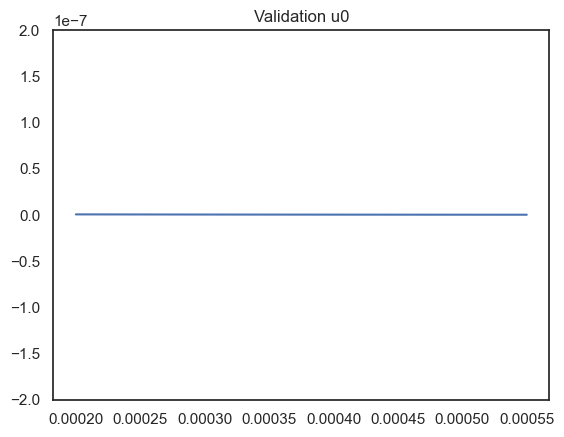

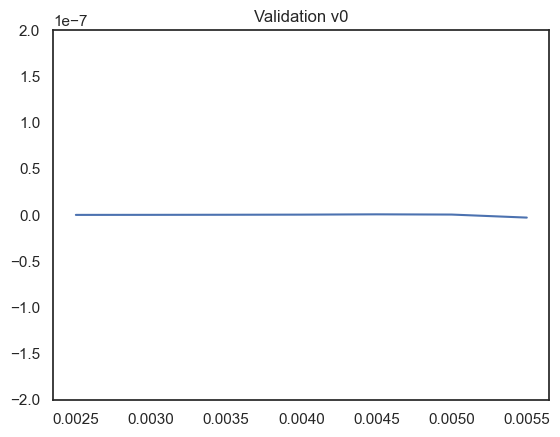

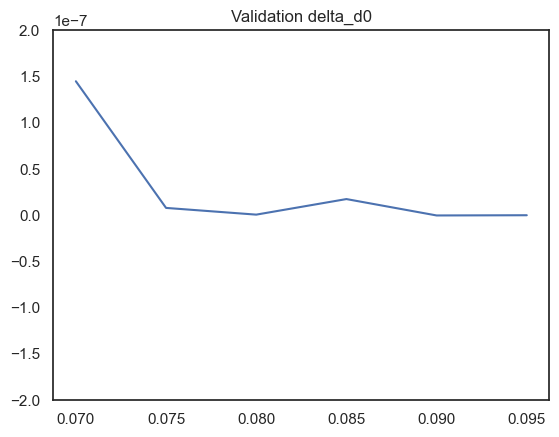

In [8]:
# HOPEFULLY HORIZONTAL LINE PLOTS

X = []
Y = []
for variable in np.arange(0.0005, 0.0015, 0.0001):
    params = {
         'DMax': 100,
         'CASE': 'Linear 2',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': 0.0004,
         'v0': 0.004,
         'lambda0': 0.04,
         'lambda1': variable,
         'delta_d0': 0.08
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
title = "Validation lambda1"
plt.title(title)
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.02, 0.055, 0.005):
    params = {
         'DMax': 100,
         'CASE': 'Linear 2',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': 0.0004,
         'v0': 0.004,
         'lambda0': variable,
         'lambda1': 0.001,
         'delta_d0': 0.08
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation lambda0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.0002, 0.0006, 0.00005):
    params = {
         'DMax': 100,
         'CASE': 'Linear 2',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': variable,
         'v0': 0.004,
         'lambda0': 0.04,
         'lambda1': 0.001,
         'delta_d0': 0.08
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation u0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.0025, 0.006, 0.0005):
    params = {
         'DMax': 100,
         'CASE': 'Linear 2',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': 0.0004,
         'v0': variable,
         'lambda0': 0.04,
         'lambda1': 0.001,
         'delta_d0': 0.08
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation v0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.07, 0.1, 0.005):
    params = {
         'DMax': 100,
         'CASE': 'Linear 2',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': 0.0004,
         'v0': 0.004,
         'lambda0': 0.04,
         'lambda1': 0.001,
         'delta_d0': variable
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation delta_d0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

In [9]:
# MODEL TYPE: 3L
einar_model = EinarPersistorModelType3L()
d = einar_model.paramDic
d

{'DMax': 100,
 'CASE': 'Linear 3',
 'n': 1500,
 'fracRes': 0.01,
 'Cmax': 10,
 'k': 0.0004,
 'm': 0.0004,
 'u0': 0.0004,
 'v0': 0.004,
 'lambda0': 0.04,
 'lambda1': 0.001,
 'delta_d0': 0.08}

In [10]:
# FUNCTIONS

from scipy.optimize import curve_fit

def expFunc(t, n0, a):
    return n0 * np.exp(np.clip(a * t, -700, 700))

def fit(results):
    start_hr = 30*24 # Make sure the start and end hour are present within the trimmed data
    end_hr = 45*24
    filtered_df = results[(results["Time"] >= start_hr) & (results["Time"] <= end_hr)]
    x_data = filtered_df["Time"].values
    y_data = filtered_df["TumourSize"].values

    params, _ = curve_fit(expFunc, x_data, y_data, p0=[3000, -0.005])
    n0_fit, a_fit = params
    
    return a_fit
    
def simulate(params):
    cfrac = params['cfrac']

    einar_model = EinarPersistorModelType3L()
    einar_model.paramDic = params
    einar_model.initialStateList = [d['n']*(1-d['fracRes']), d['n']*d['fracRes']] # Starter values
    example_schedule = [[0, 50*24, cfrac]]

    einar_model.Simulate(example_schedule, solver_kws=solver_kws)

    results = einar_model.resultsDf

    a = fit(results)

    return (sigma(params) - a)

def sigma(params):
    cmax = params['Cmax']
    cfrac = params['cfrac']
    u_0 = params['u0']
    v_0 = params['v0']
    m = params['m']
    k = params['k']
    lambda_0 = params['lambda0']
    lambda_1 = params['lambda1']
    delta_d0 = params['delta_d0']
    
    c = cmax * cfrac
    u_c = u_0 + (k*c)
    v_c = v_0 - (m*c)
    lambda_c = lambda_0 - delta_d0 * (c / (c+1))
    
    return 0.5*(lambda_c - u_c + lambda_1 - v_c + (((lambda_c - u_c - lambda_1 + v_c)**2) + (4 * u_c * v_c)) ** 0.5)

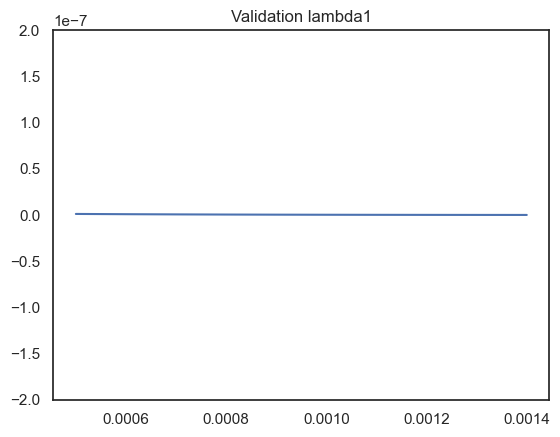

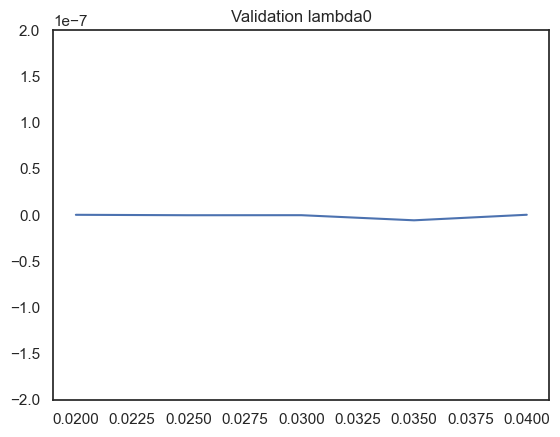

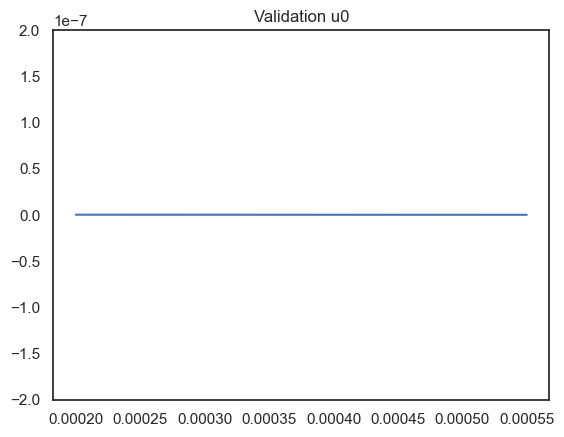

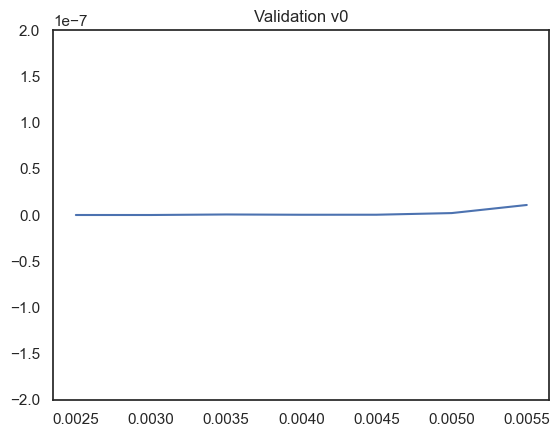

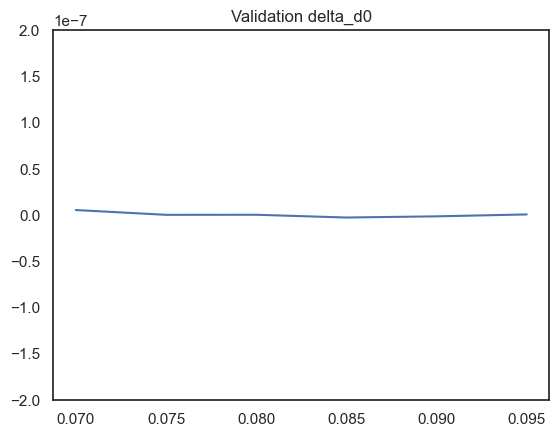

In [11]:
# HOPEFULLY HORIZONTAL LINE PLOTS

X = []
Y = []
for variable in np.arange(0.0005, 0.0015, 0.0001):
    params = {
         'DMax': 100,
         'CASE': 'Linear 3',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': 0.0004,
         'v0': 0.004,
         'lambda0': 0.04,
         'lambda1': variable,
         'delta_d0': 0.08
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
title = "Validation lambda1"
plt.title(title)
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.02, 0.045, 0.005):
    params = {
         'DMax': 100,
         'CASE': 'Linear 3',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': 0.0004,
         'v0': 0.004,
         'lambda0': variable,
         'lambda1': 0.001,
         'delta_d0': 0.08
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation lambda0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.0002, 0.0006, 0.00005):
    params = {
         'DMax': 100,
         'CASE': 'Linear 3',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': variable,
         'v0': 0.004,
         'lambda0': 0.04,
         'lambda1': 0.001,
         'delta_d0': 0.08
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation u0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.0025, 0.006, 0.0005):
    params = {
         'DMax': 100,
         'CASE': 'Linear 3',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': 0.0004,
         'v0': variable,
         'lambda0': 0.04,
         'lambda1': 0.001,
         'delta_d0': 0.08
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation v0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.07, 0.1, 0.005):
    params = {
         'DMax': 100,
         'CASE': 'Linear 3',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'k': 0.0004,
         'm': 0.0004,
         'u0': 0.0004,
         'v0': 0.004,
         'lambda0': 0.04,
         'lambda1': 0.001,
         'delta_d0': variable
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation delta_d0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

In [12]:
# MODEL TYPE: U
einar_model = EinarPersistorModelTypeU()
d = einar_model.paramDic
d

{'DMax': 100,
 'CASE': 'Uniform',
 'n': 1500,
 'fracRes': 0.01,
 'Cmax': 10,
 'u0': 0.0004,
 'v0': 0.004,
 'lambda0': 0.04,
 'lambda1': 0.001,
 'delta_d0': 0.08,
 'delta_u': 0.004,
 'delta_v': 0.003}

In [13]:
# FUNCTIONS

from scipy.optimize import curve_fit

def expFunc(t, n0, a):
    return n0 * np.exp(np.clip(a * t, -700, 700))

def fit(results):
    start_hr = 30*24 # Make sure the start and end hour are present within the trimmed data
    end_hr = 45*24
    filtered_df = results[(results["Time"] >= start_hr) & (results["Time"] <= end_hr)]
    x_data = filtered_df["Time"].values
    y_data = filtered_df["TumourSize"].values

    params, _ = curve_fit(expFunc, x_data, y_data, p0=[3000, -0.005])
    n0_fit, a_fit = params
    
    return a_fit
    
def simulate(params):
    cfrac = params['cfrac']

    einar_model = EinarPersistorModelTypeU()
    einar_model.paramDic = params
    einar_model.initialStateList = [d['n']*(1-d['fracRes']), d['n']*d['fracRes']] # Starter values
    example_schedule = [[0, 50*24, cfrac]]

    einar_model.Simulate(example_schedule, solver_kws=solver_kws)

    results = einar_model.resultsDf

    a = fit(results)

    return (sigmaU(params) - a)

def sigmaU(params):
    cmax = params['Cmax']
    cfrac = params['cfrac']
    u_0 = params['u0']
    v_0 = params['v0']
    lambda_0 = params['lambda0']
    lambda_1 = params['lambda1']
    delta_d0 = params['delta_d0']
    delta_u = params['delta_u']
    delta_v = params['delta_v']
    
    c = cmax * cfrac
    u_c = u_0 + delta_u
    v_c = v_0 - delta_v
    lambda_c = lambda_0 - delta_d0 * (c / (c+1))
    
    return 0.5*(lambda_c - u_c + lambda_1 - v_c + (((lambda_c - u_c - lambda_1 + v_c)**2) + (4 * u_c * v_c)) ** 0.5)

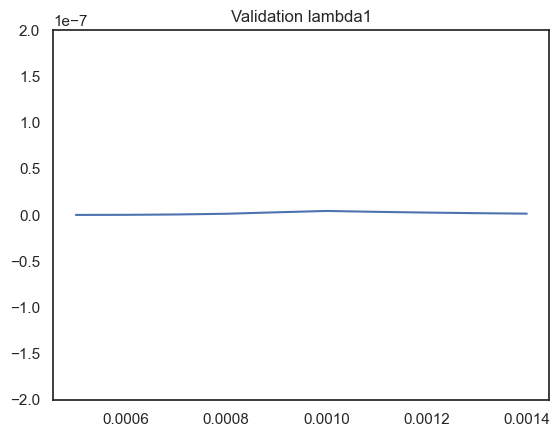

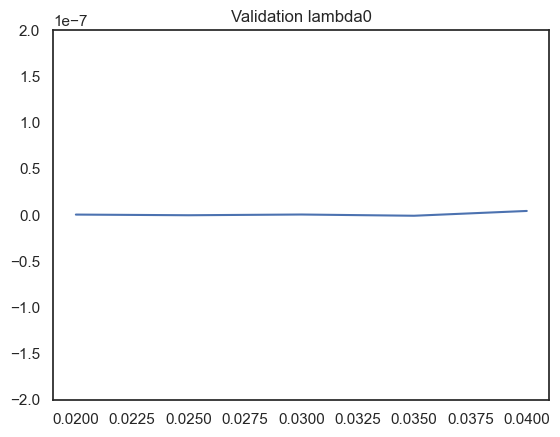

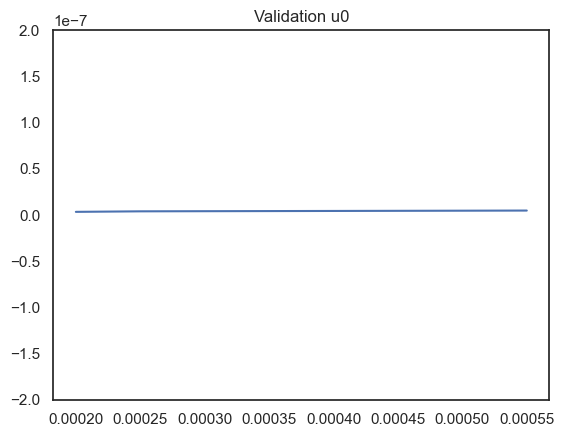

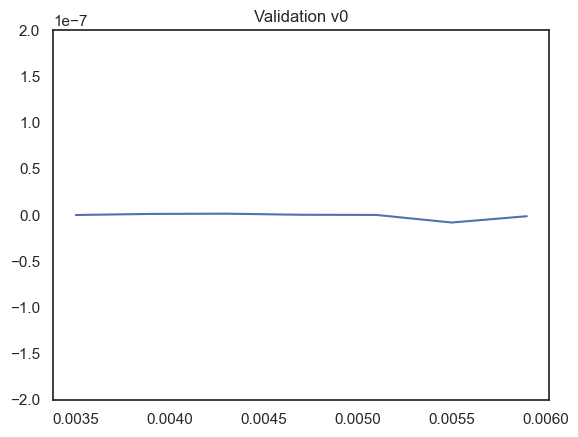

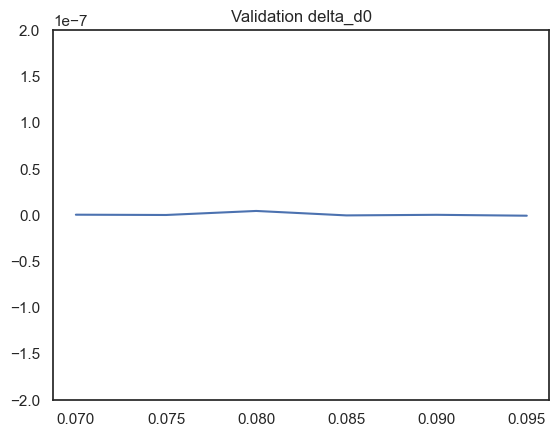

In [14]:
# HOPEFULLY HORIZONTAL LINE PLOTS

X = []
Y = []
for variable in np.arange(0.0005, 0.0015, 0.0001):
    params = {
         'DMax': 100,
         'CASE': 'Uniform',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'u0': 0.0004,
         'v0': 0.004,
         'lambda0': 0.04,
         'lambda1': variable,
         'delta_d0': 0.08,
        'delta_u': 0.004,
        'delta_v': 0.003
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
title = "Validation lambda1"
plt.title(title)
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.02, 0.045, 0.005):
    params = {
         'DMax': 100,
         'CASE': 'Uniform',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'u0': 0.0004,
         'v0': 0.004,
         'lambda0': variable,
         'lambda1': 0.001,
         'delta_d0': 0.08,
        'delta_u': 0.004,
        'delta_v': 0.003
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation lambda0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.0002, 0.0006, 0.00005):
    params = {
         'DMax': 100,
         'CASE': 'Uniform',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'u0': variable,
         'v0': 0.004,
         'lambda0': 0.04,
         'lambda1': 0.001,
         'delta_d0': 0.08,
        'delta_u': 0.004,
        'delta_v': 0.003
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation u0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.0035, 0.006, 0.0004):
    params = {
         'DMax': 100,
         'CASE': 'Uniform',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'u0': 0.0004,
         'v0': variable,
         'lambda0': 0.04,
         'lambda1': 0.001,
         'delta_d0': 0.08,
        'delta_u': 0.004,
        'delta_v': 0.003
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation v0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()

X = []
Y = []
for variable in np.arange(0.07, 0.1, 0.005):
    params = {
         'DMax': 100,
         'CASE': 'Uniform',
         'n': 1500,
         'fracRes': 0.01,
        'cfrac': 0.5,
         'Cmax': 10,
         'u0': 0.0004,
         'v0': 0.004,
         'lambda0': 0.04,
         'lambda1': 0.001,
         'delta_d0': variable,
        'delta_u': 0.004,
        'delta_v': 0.003
     }

    difference = simulate(params)

    X.append(variable)
    Y.append(difference)

plt.plot(X, Y)
plt.title('Validation delta_d0')
plt.ylim(-2*(10**(-7)), 2*(10**(-7)))
plt.savefig(f'{title}')
plt.show()